<h1>Installing RDKit</h1>

In [28]:
# !curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
# conda_installer.install()
conda_installer.install()
# !/root/miniconda/bin/conda info -e

all packages are already installed


In [29]:
import rdkit
import deepchem as dc

In [30]:
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('../Datasets/pdbbind_300.csv')
df = df.dropna()

In [33]:
df = df[:2]

<h1>Reading Mobley PDB files</h1>
<p>Here each PDB file will be read and saved in Mol data type defined in RDKit and used by DeepChem</p>

In [44]:
complex_names_df = df['complex-name'].to_numpy()
PDBs = {}
from os import listdir
from os.path import isfile, join
mypath = '../Datasets/pdbbind_complex'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for f in onlyfiles:
    if f.split('.')[0] in complex_names_df:
        PDBs.update({f.split('.')[0] : rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + '/' + f)})

<h1>Featurizing</h1>
<p>GraphConv model needs ConvMolFeaturizer</p>

In [35]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
TRAIN_SET = .8

In [37]:
X = []
X_ids = []
# one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
for k in PDBs.keys():
    X_ids.append(k)
    X.append(featurizer.featurize(PDBs[k]))
split_index = int(len(X) * TRAIN_SET)
X = [x[0] for x in X]
X_train_featurized = X[:split_index]
X_test_featurized = X[split_index:]
X_ids_train = X_ids[:split_index]
X_ids_test = X_ids[split_index:]

In [9]:
X_disk = []
y_disk = []
for i in range(len(X_ids)):
    X_disk.append(X[i])
    y_disk.append(df[df['complex-name'] == X_ids[i]]['ddg'].to_numpy()[0])
w_disk = np.ones([5,12])
X_add = []
for i in range(len(X_ids)):
    X_add.append(df[df['complex-name'] == X_ids[i]][[i for i in df.columns if ((('gb-' in i))
                                                          and ('-etot' not in i)) or ('-vdwaals' in i)]].to_numpy()[0])
train_dataset = dc.data.DiskDataset.from_numpy(X=X_disk, y=y_disk, w=w_disk, ids=X_ids)

In [10]:
x_add_train, x_add_test, y_train, y_test = [], [], [], []
for i in range(len(X_ids_train)):
    new_df = df[(df['complex-name'] == X_ids_train[i])]
    y_train.append(new_df['ddg'].to_numpy()[0])
    x_add_train.append(new_df[[i for i in df.columns if ((('gb-' in i))
                                                          and ('-etot' not in i)) or ('-vdwaals' in i)]].to_numpy()[0])
y_train = np.array(y_train)
    
for i in range(len(X_ids_test)):
    new_df = df[(df['complex-name'] == X_ids_train[i])]
    y_test.append(new_df['ddg'].to_numpy()[0])
    x_add_test.append(new_df[[i for i in df.columns if ((('gb-' in i))
                                                          and ('-etot' not in i)) or ('-vdwaals' in i)]].to_numpy()[0])
y_test = np.array(y_test)

In [11]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_test = [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

<h1>Creating Model</h1>

In [59]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
del(batch_size)

In [38]:
X_add = np.array(X_add)

In [39]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class GBGraphConvModel(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(GBGraphConvModel, self).__init__()
    self.counter = 0
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
#     inputs = inputs[0]
    x = inputs
    x_add = X_add
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
#     for i in range(len(self.input_shapes)):
#         x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
#     for i in range(1, len(self.input_shapes)):
#         x[i] = tf.cast(x[i], tf.int32)
#     x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 15])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    ans = self.dense3(binding_affinity)
    ans = tf.reshape(ans, [1, -1])
    print(ans)
    return ans
model = GBGraphConvModel(split_index)
model.compile(loss='mse', optimizer='adam')

In [40]:
def loss_function(y, y_hat, w):
    return tf.keras.losses.mse(y_hat, y)
loss_func = lambda y, y_hat, w: tf.keras.losses.mse(y_hat, y)
model2 = dc.models.KerasModel(GBGraphConvModel(len(df)), loss = loss_function)

In [41]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
import numpy as np
batch_size = len(df)
def data_generator(dataset, epochs=30):
    for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs,
                                                                   deterministic=False, pad_batches=True)):
        multiConvMol = ConvMol.agglomerate_mols(X_b)
        inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
        for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
            inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
#        inputs.append(X_add)
#         print(inputs[13])
        labels = y_b
        weights = [w_b]
        yield (inputs, labels, weights)

In [42]:
his = model2.fit_generator(data_generator(train_dataset, 1))

Tensor("gb_graph_conv_model_5/Reshape:0", shape=(1, 2), dtype=float32)


/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_11/Reshape_14:0", shape=(1497,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_11/Reshape_13:0", shape=(1497, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_11/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_11/Reshape_17:0", shape=(3636,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_11/Reshape_16:0", shape=(3636, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_g

Tensor("gb_graph_conv_model_5/Reshape:0", shape=(1, 2), dtype=float32)


In [43]:
his

3130712.0

In [126]:
# model.input_shapes = [i.shape for i in x_preprocessed_train]
history = model.fit([x_preprocessed_train], y_train.reshape([1, -1]), epochs=1)

ValueError: Data cardinality is ambiguous:
  x sizes: 13236, 11, 13236, 3940, 4760, 4534, 2, 0, 0, 0, 0, 0, 0, 4
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [88]:
model.input_shapes = [i.shape for i in x_preprocessed_test]
model.modify_graphgather(len(X) - split_index)

In [89]:
model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 0s 1ms/step - loss: 55.7400


55.7400016784668

In [28]:
np.sqrt(38.70)

6.220932405998316

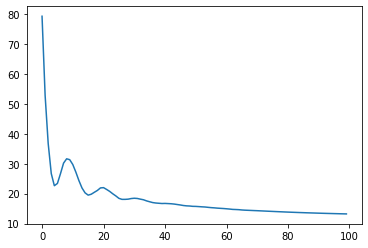

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [94]:
df.columns

Index(['ID', 'dataset group name', 'Dataset Name', 'Host', 'Guest',
       'Ex _G_(kcal/mol)', 'Ex _G_SEM', 'EX _H_(kcal/mol)', 'EX _H_SEM',
       'pb_guest_Etot', 'pb_guest_VDWAALS', 'pb_guest_EELEC', 'pb_guest_EPB',
       'pb_guest_ECAVITY', 'pb_host_Etot', 'pb_host_VDWAALS', 'pb_host_EELEC',
       'pb_host_EPB', 'pb_host_ECAVITY', 'pb_complex_Etot',
       'pb_complex_VDWAALS', 'pb_complex_EELEC', 'pb_complex_EPB',
       'pb_complex_ECAVITY', 'gb_Complex_Etot', 'gb_Complex_1-4EEL',
       'gb_Complex_EELEC', 'gb_Complex_EGB', 'gb_Complex_ESURF',
       'gb_guest_Etot', 'gb_guest_1-4EEL', 'gb_guest_EELEC', 'gb_guest_EGB',
       'gb_guest_ESURF', 'gb_host_Etot', 'gb_host_1-4EEL', 'gb_host_EELEC',
       'gb_host_EGB', 'gb_host_ESURF', 'gb_delta_H', 'pb_delta_H',
       'EX _delta_H_(kcal/mol)', 'gb_Ex_difference',
       'SQR_gbnsr6_Ex_difference', 'pb_Ex_difference'],
      dtype='object')

In [97]:
np.sqrt(np.mean((df['EX _H_(kcal/mol)'].to_numpy() - df['gb_delta_H'].to_numpy())**2))

8.485930943559929

In [98]:
(8.48 - 5.83)

2.6500000000000004